In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'ecoli.data'), names=['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 
                                                                   'aac', 'alm1', 'alm2', 'class'])

In [3]:
data.describe()

,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


In [4]:
data.drop('sequence_name', axis=1, inplace=True)
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(201, 7) (67, 7) (68, 7)
(201,) (67,) (68,)


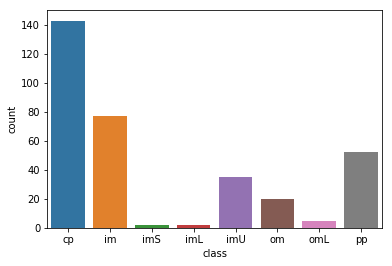

In [7]:
sns.countplot(y)

In [10]:
y_train

153     im
285     pp
13      cp
300     pp
151     im
303     pp
244    imU
105     cp
254    imU
237    imU
265     om
205     im
183     im
136     cp
63      cp
16      cp
106     cp
34      cp
305     pp
120     cp
240    imU
73      cp
145     im
210     im
51      cp
93      cp
27      cp
54      cp
286     pp
61      cp
      ... 
199     im
278     om
282    omL
100     cp
128     cp
38      cp
17      cp
299     pp
95      cp
175     im
32      cp
134     cp
141     cp
243    imU
231    imU
35      cp
77      cp
57      cp
172     im
46      cp
235    imU
169     im
332     pp
258    imU
147     im
262     om
314     pp
178     im
188     im
31      cp
Name: class, Length: 201, dtype: object

In [11]:
X_scaler = StandardScaler()
y_encoder = LabelEncoder()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_encoder.fit(y_train)
y_train = to_categorical(y_encoder.transform(y_train))
y_val = to_categorical(y_encoder.transform(y_val))
y_test = to_categorical(y_encoder.transform(y_test))

In [12]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

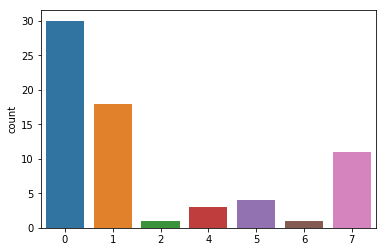

In [13]:
sns.countplot(y_test.argmax(axis=1))

In [61]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()

In [62]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Models

In [63]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(7,), kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Activation('relu'),
    keras.layers.Dense(8, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Activation('softmax')
])
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


In [65]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [66]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 201 samples, validate on 67 samples
Epoch 1/1000
201/201 [==============================] - 0s 2ms/step - loss: 2.5262 - acc: 0.0398 - val_loss: 2.4546 - val_acc: 0.0299
Epoch 2/1000
201/201 [==============================] - 0s 86us/step - loss: 2.4692 - acc: 0.0498 - val_loss: 2.4073 - val_acc: 0.0448
Epoch 3/1000
201/201 [==============================] - 0s 143us/step - loss: 2.4166 - acc: 0.0597 - val_loss: 2.3597 - val_acc: 0.0597
Epoch 4/1000
201/201 [==============================] - 0s 135us/step - loss: 2.3632 - acc: 0.0945 - val_loss: 2.3145 - val_acc: 0.0597
Epoch 5/1000
201/201 [==============================] - 0s 141us/step - loss: 2.3150 - acc: 0.1095 - val_loss: 2.2715 - val_acc: 0.1045
Epoch 6/1000
201/201 [==============================] - 0s 244us/step - loss: 2.2657 - acc: 0.1393 - val_loss: 2.2300 - val_acc: 0.1493
Epoch 7/1000
201/201 [==============================] - 0s 181us/step - loss: 2.2205 - acc: 0.1642 - val_loss: 2.1903 - val_acc: 0.2239
Epoch 

Epoch 120/1000
201/201 [==============================] - 0s 116us/step - loss: 0.7869 - acc: 0.8259 - val_loss: 0.8779 - val_acc: 0.7910
Epoch 121/1000
201/201 [==============================] - 0s 122us/step - loss: 0.7841 - acc: 0.8259 - val_loss: 0.8763 - val_acc: 0.7910
Epoch 122/1000
201/201 [==============================] - 0s 121us/step - loss: 0.7813 - acc: 0.8259 - val_loss: 0.8743 - val_acc: 0.7910
Epoch 123/1000
201/201 [==============================] - 0s 124us/step - loss: 0.7785 - acc: 0.8308 - val_loss: 0.8727 - val_acc: 0.7910
Epoch 124/1000
201/201 [==============================] - 0s 105us/step - loss: 0.7756 - acc: 0.8358 - val_loss: 0.8699 - val_acc: 0.7910
Epoch 125/1000
201/201 [==============================] - 0s 116us/step - loss: 0.7730 - acc: 0.8358 - val_loss: 0.8676 - val_acc: 0.7910
Epoch 126/1000
201/201 [==============================] - 0s 110us/step - loss: 0.7703 - acc: 0.8358 - val_loss: 0.8656 - val_acc: 0.7910
Epoch 127/1000
201/201 [==========

201/201 [==============================] - 0s 118us/step - loss: 0.6377 - acc: 0.8756 - val_loss: 0.7358 - val_acc: 0.8209
Epoch 239/1000
201/201 [==============================] - 0s 126us/step - loss: 0.6375 - acc: 0.8806 - val_loss: 0.7351 - val_acc: 0.8209
Epoch 240/1000
201/201 [==============================] - 0s 111us/step - loss: 0.6374 - acc: 0.8756 - val_loss: 0.7349 - val_acc: 0.8209
Epoch 241/1000
201/201 [==============================] - 0s 96us/step - loss: 0.6369 - acc: 0.8756 - val_loss: 0.7336 - val_acc: 0.8358
Epoch 242/1000
201/201 [==============================] - 0s 106us/step - loss: 0.6364 - acc: 0.8706 - val_loss: 0.7342 - val_acc: 0.8209
Epoch 243/1000
201/201 [==============================] - 0s 119us/step - loss: 0.6361 - acc: 0.8706 - val_loss: 0.7356 - val_acc: 0.8060
Epoch 244/1000
201/201 [==============================] - 0s 133us/step - loss: 0.6356 - acc: 0.8706 - val_loss: 0.7356 - val_acc: 0.8060
Epoch 245/1000
201/201 [==========================

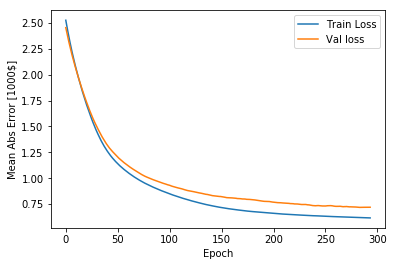

In [67]:
plot_history(history)

In [68]:
pred = np.round(model.predict(X_test).argmax(axis=1).reshape(-1,))
accuracy_score(pred, y_test.argmax(axis=1))

0.8529411764705882

[[28  0  0  0  0  0  0  0]
 [ 1 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  6  1  0  3  0  0  0]
 [ 0  0  0  0  0  4  0  1]
 [ 0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0 10]]


/Users/SimonMcDonnell/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


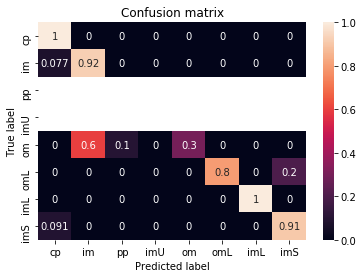

In [71]:
mat = confusion_matrix(pred, y_test.argmax(axis=1), labels=[0, 1, 2, 3, 4, 5, 6, 7])
print(mat)
cm = mat / np.sum(mat, axis=1).reshape(-1, 1)
plot_confusion_matrix(cm, classes=['cp', 'im', 'pp', 'imU', 'om', 'omL', 'imL', 'imS'])